### Unpaired OT

This notebook reproduces the experiment on deforestation data as an example for *unpaired OT*. (Appendix B)

In [1]:
import psycopg2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
from scipy.stats import spearmanr
import json
from scipy.stats import norm
from sklearn.metrics import mean_absolute_percentage_error

from scipy.spatial.distance import cdist
import wasserstein
from matplotlib.lines import Line2D

from datetime import datetime
from collections import defaultdict
import torch
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
plt.rcParams.update({"font.size":15})

In [2]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#### Read data -  deforestation data (taken from https://github.com/FSantosCodes/GWRFC/tree/master/data)

In [3]:
ds = pd.read_csv(os.path.join("..", "data_submission", "deforestation.csv"))

In [4]:
label_col = "deforestation_quantile"
inp_data = ds.drop([label_col], axis=1) # , "x", "y"
labels = ds[label_col]

# randomly divide into train and test data
np.random.seed(42)
inds = np.random.permutation(inp_data.index)
len_train = int(len(inp_data) * 0.8)
train_inds, test_inds = inds[:len_train], inds[len_train:]
train_x, train_y, test_x, test_y = inp_data.loc[train_inds], labels.loc[train_inds], inp_data.loc[test_inds], labels.loc[test_inds]

In [5]:
rf = RandomForestClassifier(n_estimators=100)

In [6]:
rf.fit(train_x, train_y)

RandomForestClassifier()

In [7]:
out_pred = rf.predict(test_x)

In [8]:
accuracy_score(out_pred.round(), test_y)

0.5785123966942148

In [9]:
confusion_matrix(test_y, out_pred)

array([[83, 30,  9,  2],
       [26, 45, 33, 10],
       [ 7, 30, 69, 24],
       [ 0, 10, 23, 83]])

In [10]:
print(classification_report(test_y, out_pred))

              precision    recall  f1-score   support

           1       0.72      0.67      0.69       124
           2       0.39      0.39      0.39       114
           3       0.51      0.53      0.52       130
           4       0.70      0.72      0.71       116

    accuracy                           0.58       484
   macro avg       0.58      0.58      0.58       484
weighted avg       0.58      0.58      0.58       484



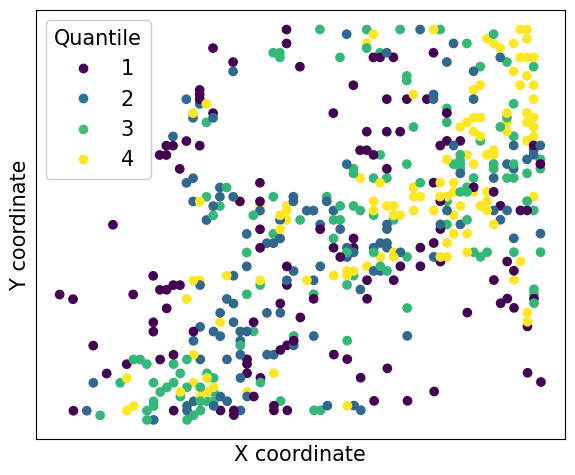

In [11]:
# high deforestation gt vs high deforestation real
plt.figure(figsize=(6,5))
scatter = plt.scatter(inp_data.loc[test_inds, "x"], inp_data.loc[test_inds, "y"], c=labels.loc[test_inds])
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.xticks([])
plt.yticks([])
legend_elements = [Line2D([0], [0], marker='o', markeredgecolor=mpl.colormaps["viridis"](0), markerfacecolor=mpl.colormaps["viridis"](0), markersize=6, label='1', lw=0),
                   Line2D([0], [0], marker='o',  markerfacecolor=mpl.colormaps["viridis"](100), markersize=6, label='2', lw=0),
                  Line2D([0], [0],  marker='o', markeredgecolor=mpl.colormaps["viridis"](180), markerfacecolor=mpl.colormaps["viridis"](180), markersize=6,label='3', lw=0),
                  Line2D([0], [0],  marker='o', markeredgecolor=mpl.colormaps["viridis"](500),  markerfacecolor=mpl.colormaps["viridis"](300), markersize=6, label='4', lw=0)
                  ]
# Create the figure
plt.legend(handles=legend_elements, title="Quantile", loc="upper left", framealpha=1)
# plt.legend()
plt.tight_layout()
# plt.savefig("figures/deforestation_quantiles.pdf")
plt.show()

## 4th quantile analysis

In [12]:
pred_q4 = test_x.loc[out_pred == 4]
gt_q4 = test_x.loc[test_y == 4]
len(pred_q4), len(gt_q4)

(119, 116)

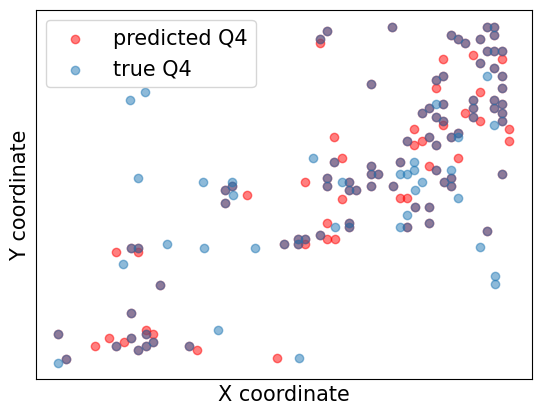

In [13]:
# high deforestation gt vs high deforestation real
plt.scatter(pred_q4["x"], pred_q4["y"], alpha=0.5, label="predicted Q4", c="red")
plt.scatter(gt_q4["x"], gt_q4["y"], alpha=0.5, label="true Q4")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

In [14]:
import ot
import ot.plot

In [15]:
coords_pred_q4 = pred_q4[["x", "y"]].values
coords_gt_q4 = gt_q4[["x", "y"]].values

#### partial OT

Here, we need to export and import from a specific point, but we do it with cost 0, so it should be fine. 

In [16]:
# length of pred > length of gt
len_diff = len(pred_q4) - len(gt_q4)
assert len_diff > 0
gt_extended = np.concatenate([coords_gt_q4, np.zeros((len_diff, 2))])
a = np.ones(len(coords_pred_q4)) / len(coords_pred_q4)
b = np.ones(len(gt_extended)) / len(gt_extended)
cost_matrix = cdist(coords_pred_q4, gt_extended)
cost_matrix[:, -len_diff:] = 0
transport_matrix = ot.emd(a, b, cost_matrix)

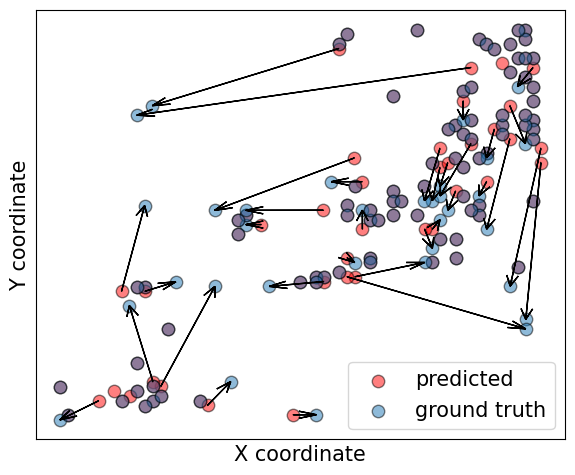

In [17]:
plt.figure(figsize=(6,5))
# plot points
scatter_size = 80
plt.scatter(test_x.loc[out_pred == 4, "x"], test_x.loc[out_pred == 4, "y"], alpha=0.5, label="predicted", c="red", edgecolor="black", s=scatter_size)
plt.scatter(test_x.loc[test_y == 4, "x"], test_x.loc[test_y == 4, "y"], alpha=0.5, label="ground truth", edgecolor="black", s=scatter_size)
# plot arrows
for i, (x1, y1) in enumerate(coords_pred_q4):
    for j, (x2, y2) in enumerate(coords_gt_q4):
        if (i != j) and (transport_matrix[i,j] > 0) and (x1 != x2):
            plt.arrow(x1, y1, x2-x1, y2-y1, head_width=3000, length_includes_head=True, overhang=1)

plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.xticks([])
plt.yticks([])
plt.legend(loc="lower right")
plt.tight_layout()
# plt.savefig("figures/deforestation.pdf")
plt.show()